In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os.path as op
import time

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import SVG
from keras.callbacks import TensorBoard
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback

from data import im_generator
from unet import unet

Using TensorFlow backend.


In [2]:
# print models as seen by tf
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [3]:
model = unet(input_size=(28, 28, 1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/zaccharie/workspace/understanding-unets/unet.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input=inputs, output=conv6)


In [14]:
model.weights

[<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 1) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 1, 1) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'conv2d_3/kernel:0' shape=(3, 3, 1, 1) dtype=float32_ref>,
 <tf.Variable 'conv2d_3/bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'conv2d_4/kernel:0' shape=(3, 3, 2, 1) dtype=float32_ref>,
 <tf.Variable 'conv2d_4/bias:0' shape=(1,) dtype=float32_ref>]

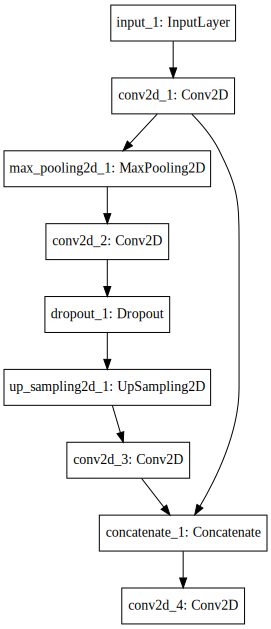

In [4]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [6]:
batch_size = 32
noise_std = 30
im_gen_train = im_generator(mode='training', validation_split=0.1, batch_size=batch_size, source='mnist', noise_std=noise_std)
im_gen_val = im_generator(mode='validation', validation_split=0.1, batch_size=batch_size, source='mnist', noise_std=noise_std)
im_gen_test = im_generator(mode='testing', batch_size=batch_size, source='mnist', noise_std=noise_std)

In [7]:
log_dir = op.join('logs', str(time.clock()))
tboard_cback = TensorBoard(
    log_dir=log_dir, 
    histogram_freq=1, 
    batch_size=batch_size, 
    write_graph=True, 
    write_images=True, 
)

In [8]:
history = model.fit_generator(
    im_gen_train, 
    steps_per_epoch=int(0.9*5*1e4 / 32), 
    epochs=50,
    validation_data=next(im_gen_val),
    validation_steps=int(0.1*5*1e4 / 32),
#     validation_freq=2,
    verbose=0,
#     use_multiprocessing=True,
    callbacks=[TQDMNotebookCallback(), tboard_cback],
)

Instructions for updating:
Use tf.cast instead.


In [9]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

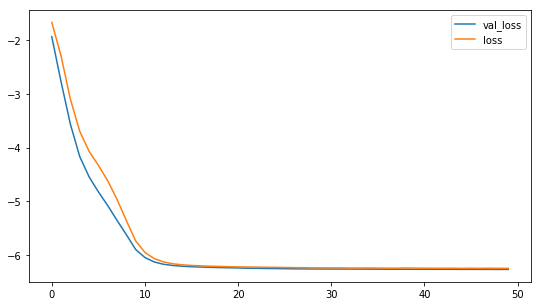

In [10]:
plt.figure(figsize=(9, 5))
for key, val in history.history.items():
    plt.plot(np.log(val), label=key)
plt.legend()

In [11]:
batch_test_noisy, batch_test_gt = next(im_gen_test)

In [12]:
batch_test_pred = model.predict(batch_test_noisy)

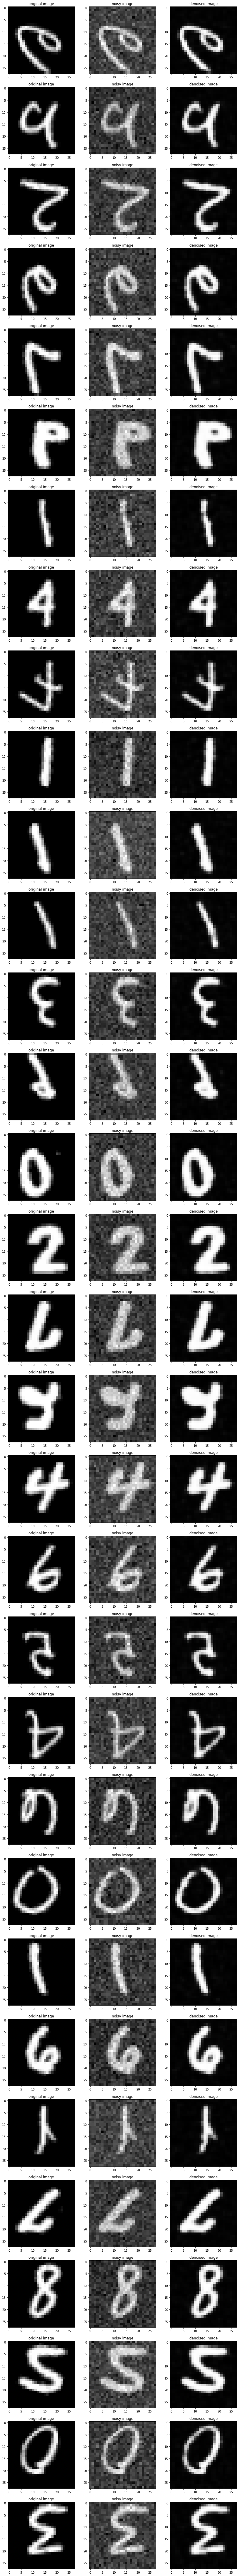

In [13]:
fig, axs = plt.subplots(32, 3, figsize=(14, 32*5))
for example_id in range(32):
    
    axs[example_id, 0].imshow(batch_test_gt[example_id, ..., 0], cmap='gray')
    axs[example_id, 0].set_title("original image")
    axs[example_id, 1].imshow(batch_test_noisy[example_id, ..., 0], cmap='gray')
    axs[example_id, 1].set_title("noisy image")
    axs[example_id, 2].imshow(batch_test_pred[example_id, ..., 0], cmap='gray')
    axs[example_id, 2].set_title("denoised image")